# TRABAJO PRÁCTICO 11 - PYMC

In [6]:
# LIBRERIAS
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

# Inciso A

##  Cargar la base de datos TA136.csv y reemplazar los datos faltantes por np.nan.

In [7]:
X = pd.read_csv('TA136.csv', sep=',')
X = X.replace([""], np.nan)
print(X.shape)

X= X.head(10)

# Se elimina la primer columna, que contiene 'usuario id'
X = X.iloc[:, 1:]

# Se convierte el array a array de numpy
X = X.values

I, J = X.shape
print("I =", I, "J =", J)


(70, 21)
I = 10 J = 20


# Inciso B

## Construir el modelo bayesiano en PyMC:

El conocimiento del usuario i−ésimo sería representado por $θ_i ∼ N (µ_θ, σ^{2}_θ)$ , mientras que la dificultad de la tarea j−ésima sería representada por $β_j ∼ N (µ_β, σ^{2}_β)$. A priori se asumiría que $µ_θ$, $µ_β$ ∼ $N (0, 1)$ y $σ_θ, σ_β ∼ exp(1)$. Finalmente, la variable observable (resuelve o no resuelve la tarea) sería de la forma $X_{i,j} ∼ Ber (σ(θ_i − β_j ))$ donde $σ(·)$ es la función sigmoide.

In [8]:
# Se define el modelo bayesiado descripto
with pm.Model() as bayesian_model:

    mu_theta = pm.Normal("mu_theta", mu=0.0, sigma=1.0)
    mu_beta  = pm.Normal("mu_beta",  mu=0.0, sigma=1.0)

    sigma_theta = pm.Exponential("sigma_theta", 1.0)
    sigma_beta  = pm.Exponential("sigma_beta", 1.0)

    theta = pm.Normal("theta", mu=mu_theta, sigma=sigma_theta, shape=I)
    beta  = pm.Normal("beta",  mu=mu_beta,  sigma=sigma_beta,  shape=J)

    # arg es el argumento de la sigmoide.
    arg = theta[:, None] - beta[None, :]

    # PYMC aplica la función sigmoide a arg en la distribución Bernoulli,
    # cuando se usa el campo "logits"
    X = pm.Bernoulli("X", logit_p=arg, observed=X)


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\pymc\model\core.py:1286: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in X contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


# Inciso C

## Utilizando model_to_graphviz (PyMC), graficar la red bayesiana. ¿Cómo interpreta la red los datos faltantes?

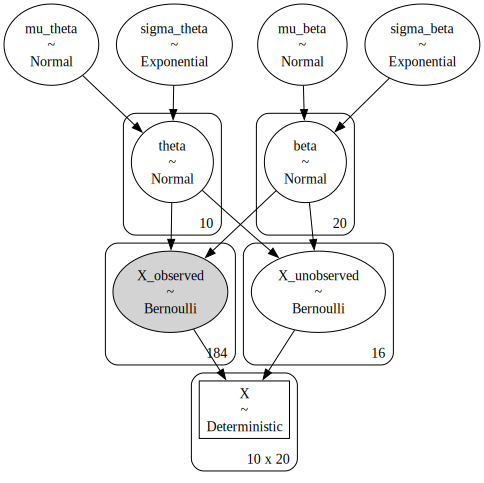

In [9]:
pm.model_to_graphviz(bayesian_model)

La red bayesiana, es un modelo de cómo se supone que fueron generados los datos X. En este caso, los datos faltantes, la red los interpreta como "no observados". En este caso, 134 de los 1400 valores posibles (70x20) son no observados.

# Inciso D

## Muestrear 3 cadenas del experimento. Elegir los parámetros draws, tune y target accept de manera de alcanazar un ESS (bulk) > 30 y un $\hat{R}$ menor o igual que 1.1, en todos los $θ_i$ y $β_j$. La función summary (arviz) puede ser útil.

In [ ]:
with bayesian_model:
    idata = pm.sample(
        draws=250, # Cuantas muestras se quieren guardar por cadena una vez que hizo el aprendizaje
        tune=1000, # Cuantas muestras usa el sampler para aprender como moverse en el espacio de parámetros no se guardan
        chains=3, # Cantidad de cadenas independientes deseadas
        target_accept=0.9, 
        return_inferencedata=True
    )
    
# Se calculan parámetros para las variables theta y beta
summary = az.summary(idata, var_names=["theta", "beta"])
print(summary)

# Se verifica el cumplimiento de los criterios
ess_ok  = summary["ess_bulk"].min() > 30
rhat_ok = summary["r_hat"].max() <= 1.1

print("\n--- Evaluación de criterios ---")
print("ESS_bulk > 30 :", ess_ok)
print("R̂ ≤ 1.1      :", rhat_ok)

if ess_ok and rhat_ok:
    print("\nCriterios alcanzados")
else:
    print("\nCriterios NO alcanzados — aumentar draws, tune o target_accept")

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [mu_theta, mu_beta, sigma_theta, sigma_beta, theta, beta]
>BinaryGibbsMetropolis: [X_unobserved]


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 500 tune and 250 draw iterations (1_500 + 750 draws total) took 612 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.215  0.834  -1.386    1.636      0.102    0.035      68.0   
theta[1] -0.197  0.831  -1.737    1.255      0.151    0.038      31.0   
theta[2]  0.492  0.858  -0.911    2.201      0.156    0.036      30.0   
theta[3] -1.293  0.849  -2.714    0.429      0.124    0.035      47.0   
theta[4]  0.559  0.856  -0.906    2.149      0.146    0.035      35.0   
theta[5]  1.031  0.884  -0.498    2.726      0.147    0.041      36.0   
theta[6] -0.743  0.845  -2.284    0.754      0.103    0.029      71.0   
theta[7]  1.079  0.880  -0.493    2.763      0.155    0.038      33.0   
theta[8]  1.716  0.951  -0.150    3.323      0.131    0.042      55.0   
theta[9]  0.233  0.848  -1.193    1.850      0.115    0.036      54.0   
beta[0]  -1.035  0.968  -2.732    0.899      0.132    0.033      54.0   
beta[1]   0.688  0.938  -0.978    2.414      0.145    0.039      41.0   
beta[2]  -0.611  0.907  -2.305    1.100      0.122 